# Systems of Linear Equations
A lot of numerical problems boil down to solving systems of linear equations such as,
$$
\begin{array}{llll}
x_1 & + & x_2   & &     & = 1 \\
    &  & x_2 & + & x_3 & = 4 \\
x_1 & + & 2x_2 & + & 3x_3 & = 6
\end{array}
$$
Obviously, this can be written as a matrix equation,
$$\left(
\begin{matrix}
1 & 1 & 0 \\
0 & 1 & 1 \\
1 & 2 & 3
\end{matrix}
\right) \left(
\begin{array}{c}
x_1 \\
x_2 \\
x_3
\end{array} \right) = \left(
\begin{array}{c}
1 \\
4 \\
6
\end{array} \right).
$$
Solving for the unknowns involves finding the inverse of the squart matrix and multiplying through by it,
$$
\left(
\begin{array}{c}
x_1 \\
x_2 \\
x_3
\end{array}
\right) = \left(
\begin{matrix}
1 & 1 & 0 \\
0 & 1 & 1 \\
1 & 2 & 3
\end{matrix}
\right)^{-1}
\left(
\begin{array}{c}
1 \\
4 \\
6
\end{array} \right).
$$

In [1]:
import numpy as np
import scipy.sparse
import scipy.sparse.linalg

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#  Set up the square matrix above and the column vector that represents the right-hand side
A = np.array( [ [1,1,0], [0, 1, 1], [1, 2, 3] ])
y = np.array( [1, 4, 6] )
#  This isn't necessary, but I like to explicitly make this a column vectory.shape = (3, 1)

#  Invert the matrix and find the vector of unkowns my multiplying though
A_inv = np.linalg.inv(A)
x = np.matmul(A_inv, y)

#  Print the results
print(x)

#  Solve the same problem using the built-in solve command
x = np.linalg.solve(A, y)
print(x)

[-2.5  3.5  0.5]
[-2.5  3.5  0.5]


# Sparse Matrices
In many cases, we will encounter problems of the form  $Ax = y$ where most of the entries of $A$ are zero.  These are called sparse matrices.

In another video we will look at simulating a large number of  potential stock prices.  We will use a random walk model where the stock on the $i+1$ day can be calculated from its price on the $i$th day.  The equation is,
$$ \frac{S_{i+1} - S_i}{S_i} = r\Delta t + \sqrt{\Delta t}\sigma \epsilon_i. $$
Here, $\Delta t$ is the time increment,  $\sigma$ is the volatility, $r$ is the risk-free rate, and $\epsilon$ is a number sampled from the normal distribution.  For this example, we will create a vector of $\epsilon$ using the stats package  and just treat it as a known vector.  We can rearrange the above equation and write, 
$$
S_{i+1} = S_i \left(r\Delta t + \sqrt{\Delta t}\sigma \epsilon_i\right) + S_i.
$$
Just to keep the notation a bit cleaner, we will write,
$$r\Delta t + \sqrt{\Delta t}\sigma \epsilon_i = \Lambda_i.$$

If we write out all of our stock prices explicitly, we get,

$$\begin{array}{lcl}S_0                     & = & S_0 \\S_1 - S_0 \Lambda_1 - S_0 & = &  0\\\S_2 - S_1 \Lambda_2 - S_1 & = & 0 \\S_3 - S_2 \Lambda_3 - S_2 & = & 0 \\& \vdots & \\S_i - _{i-} \Lambda_i - S_{i-1} & = & 0 .\\\end{array}$$

This is a system of linear equations and can be cast in matrix form as,

$$ \left( \begin{matrix} 1 & 0 & 0 & 0 & \cdots & 0 \\ \Lambda_1 + 1 & -1 & 0 & 0 & \cdots & 0 \\ 0 & \Lambda_2 + 1 & -1 & 0 & \cdots & 0 \\ 0 & 0 & \Lambda_3 + 1 & -1 & \cdots & 0  \\ \vdots & \vdots & \vdots & \vdots & \ddots & \vdots \\ 0 & 0 & 0 & 0 & \Lambda_5 + 1 & -1 \end{matrix} \right) \left( \begin{array}{c} S_0 \\ S_1 \\ S_2 \\ S_3 \\ \vdots \\ S_i \\ \end{array} \right) = \left( \begin{array}{c} S_0 \\ 0 \\ 0 \\ 0 \\ \vdots \\ 0 \\ \end{array} \right). \label{simple_matrix} $$

Notice most of the entries of the square matrix are zero.

In [3]:
#  Since we are using this as an example only, set a constant random seed.  This is also useful for debugging code with random numbers involved.
np.random.seed(0)

#  Define:
#  Initial stock price
#  Numer of days
#  Risk-free rate
#  Volatility
S0 = 100.0
N_days = 30
r = 0.01
sigma = 0.30

#  Scale interest rates and volatility.  Define time-step.
r = r / 252.
dt = 1.0
sigma = sigma / np.sqrt(252.0)

In [4]:
#  Create a vector of random numbers
epsilon = np.random.normal( size = (N_days) )

#  Calculate the daily percent change in stock price
Lambda = r * dt + sigma * np.sqrt(dt) * epsilon

[100.         103.33771383 104.12328124 106.05331994 110.54876994
 114.45481297 112.34550995 114.36712987 114.04453453 113.8265988
 114.71436259 115.03118647 118.19717469 119.90180769 120.18227291
 121.19515819 121.96420626 125.4127592  124.93149473 125.67559995
 123.65207075 117.69113952 119.14955788 121.10074998 119.40704483
 124.53366845 121.11581137 121.22535302 120.80133587 124.30535824
 127.76203582]


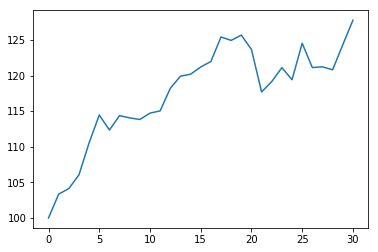

In [5]:
#  Create the vector that will be the main diagonal
ones = -np.ones( (N_days + 1) ); ones[0] = 1

#  Create our diagonal vectors.  The first element will be the diagonal below the main, and the second will be the main.
d = [ Lambda + 1, ones]

#  Set up the offset vector that defines the positions we describe above.
K = [-1, 0]

#  Create our sparse matrix
M = scipy.sparse.diags(d, K, format = 'csc')

#  Define our vector of knowns.  This is the right-hand side of the matrix equation above
p = np.zeros( (N_days + 1, 1) )
p[0] = S0

#  Solve the problem and print the results
s = scipy.sparse.linalg.spsolve(M, p)
print(s )

#  Plot the results
t = np.arange(0, N_days + 1)
plt.plot(t, s)
#plt.spy(M)
